
### import Neseccary packages


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score,
    roc_curve, roc_auc_score, confusion_matrix, classification_report ,ConfusionMatrixDisplay
)
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder,StandardScaler
from warnings import filterwarnings

# Suppress warnings
filterwarnings('ignore')



### Fetch the MNIST dataset



In [16]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]



### Display dataset info



In [17]:

print(mnist.frame.info())
print(mnist.keys())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to class
dtypes: category(1), int64(784)
memory usage: 418.8 MB
None
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])




### Visualize an example image



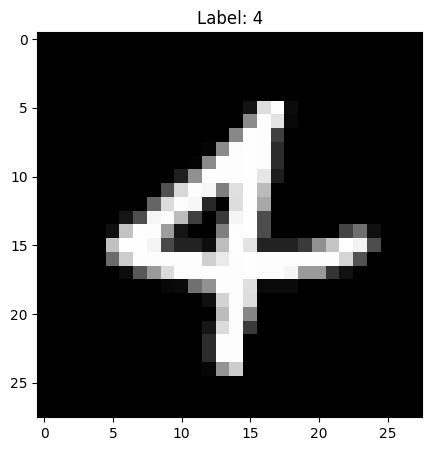

In [18]:
plt.figure(figsize=(5, 5))
some_digit = 150
some_digit_image = X.iloc[some_digit].to_numpy().reshape(28, 28)
plt.imshow(some_digit_image, cmap=plt.cm.gray)
plt.title(f"Label: {y[some_digit]}")
plt.show()




#### Function to visualize multiple images



In [19]:

def print_image(row, df):

    temp = df.iloc[row, :].values
    temp = temp.reshape(28, 28).astype('uint8')
    plt.imshow(temp, cmap='gray')
    plt.show()



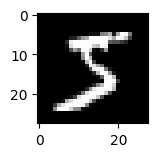

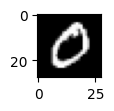

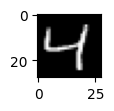

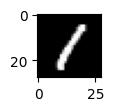

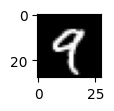

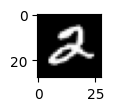

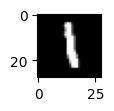

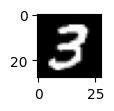

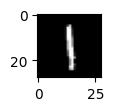

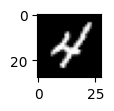

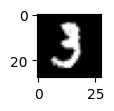

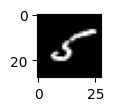

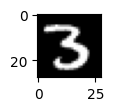

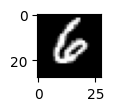

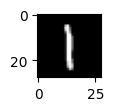

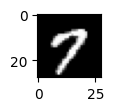

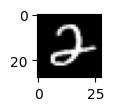

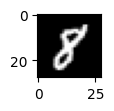

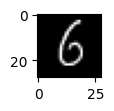

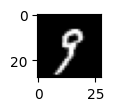

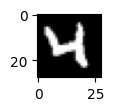

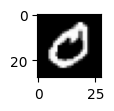

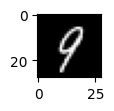

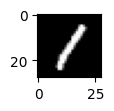

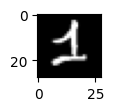

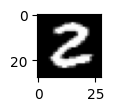

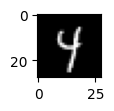

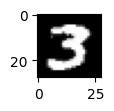

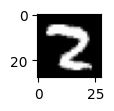

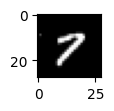

In [20]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5, 6, i+1)
    print_image(i,X )



### Class distribution



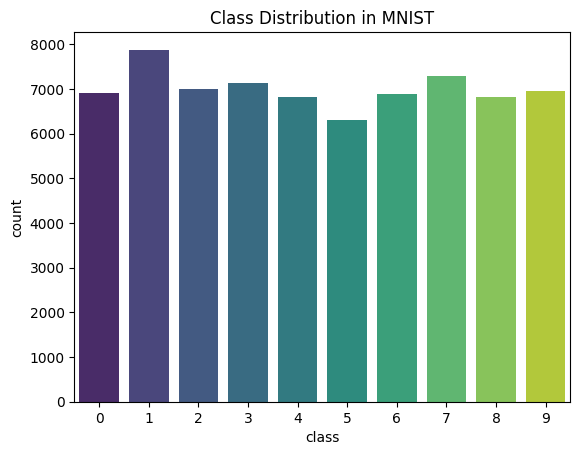

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64


In [21]:
sns.countplot(x=mnist['target'], palette="viridis")
plt.title("Class Distribution in MNIST")
plt.show()

print(mnist['target'].value_counts())



### Split dataset into training and test sets



In [22]:
# Reduce data size for quicker testing (remove this if full MNIST is desired for final run)
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.5, stratify=y, random_state=4)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42, stratify=y_small)



### Preprocessing: Scale the features



In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)





#### Models to Evaluate




In [25]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),

}



#### Create a VotingClassifier with a subset of models




In [26]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
        ("gb", models["Gradient Boosting"])
    ],
    voting="soft"  # Using 'soft' voting for better performance
)

In [27]:
models["Voting Classifier"] = voting_clf

In [ ]:
cv_scores = {}
for name, model in models.items():
    print(f"Evaluating {name}:")
    # Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Using StratifiedKFold for balanced class splits
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_scores[name] = scores

    print(f"  Cross-validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

    # Training and Evaluation on Test Set
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("  Classification Report:\n", classification_report(y_test, y_pred))

Evaluating Logistic Regression:





#### Compare Cross-Validation Scores




In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(cv_scores))
plt.title("Cross-Validation Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.show()